In [12]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from math import pi
import torch

dtype = torch.double
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def kepler_orbit(initial_conditions, t_max=None, dt=0.001):
    
    def equations(t, xps):
        x, y, z , px, py, pz = xps
        dxdt = px
        dydt = py
        dzdt = pz
        dpxdt = -x
        dpydt = -y
        dpzdt = -z
        return [dxdt, dydt, dzdt, dpxdt, dpydt, dpzdt]
    def equations(t, xps):
        x, y, z , px, py, pz = xps
        dxdt = px
        dydt = py
        dzdt = pz
        dpxdt = - x / (x**2 + y**2 + z**2)**(3/2)
        dpydt = - y / (x**2 + y**2 + z**2)**(3/2)
        dpzdt = - z / (x**2 + y**2 + z**2)**(3/2)
        return [dxdt, dydt, dzdt, dpxdt, dpydt, dpzdt]

    t_eval = np.arange(0, t_max, dt)
    sol = solve_ivp(equations, [0, t_max], initial_conditions, t_eval=t_eval, atol=1e-10, rtol=1e-8)
    out = [sol.y[i] for i in range(6)]

    return np.column_stack(out)

def energy_kep(xps):
    "energy function of Kepler problem"
    return ((xps[:,3:]**2).sum(-1) / 2 - 1 / torch.norm(xps[:,:3], dim=-1)).view(-1, 1) # (..., 1)

In [14]:
def potential(data, tgt):
    "potential function for HMC"
    return ((energy_kep(data) - tgt)**2).view(-1)

class HMCSampler():
    def __init__(self, energy):
        self.energy = energy

    def grad_energy(self, x, tgt):
        with torch.enable_grad():
            x.requires_grad_(True)
            total_energy = self.energy(x, tgt).sum()
            grad_energy = torch.autograd.grad(total_energy, x)[0]
        x.requires_grad_(False)
        return grad_energy

    def leap_frog(self, x0, p0, tgt, dt=0.01, traj_len=32):
        with torch.no_grad():
            x, p = x0, p0
            p = p - 0.5 * dt * self.grad_energy(x, tgt)
            x = x + dt * p
            for t in range(traj_len):
                p = p - dt * self.grad_energy(x, tgt)
                x = x + dt * p
            p = p - 0.5 * dt * self.grad_energy(x, tgt)
        return x, p

    def hamiltonian(self, x, p, tgt):
        V = self.energy(x, tgt)
        K = (p ** 2).sum(-1) / 2
        return K + V

    def step(self, x0, tgt, **kwargs):
        p0 = torch.randn_like(x0)
        H0 = self.hamiltonian(x0, p0, tgt)
        x, p = self.leap_frog(x0, p0, tgt, **kwargs)
        H = self.hamiltonian(x, p, tgt)
        prob_accept = torch.exp(H0 - H)
        mask = prob_accept > torch.rand_like(prob_accept)
        x = torch.where(mask[...,None], x, x0)
        return x

    def update(self, x, tgt, steps=1, **kwargs):
        for _ in range(steps):
            x = self.step(x, tgt, **kwargs)
        return x
    
def get_data(N=100, tgt=-5, steps=100):
    sampler = HMCSampler(potential)
    init_data = torch.randn((N, 6), device=device, dtype=dtype)
    init_data = sampler.update(init_data, tgt, steps)
    init_data = init_data[energy(init_data).view(-1) < 0]
    return init_data.requires_grad_(True)

In [17]:
def get_data(N=100, tgt=-5, steps=100):
    sampler = HMCSampler(potential)
    init_data = torch.randn((N, 6), device=device, dtype=dtype)
    init_data = sampler.update(init_data, tgt, steps)
    init_data = init_data[energy_kep(init_data).view(-1) < 0]
    return init_data.requires_grad_(True)

In [18]:
X = []
data = get_data(N=200)
for d in data:
    out = kepler_orbit(d.tolist(), t_max=10, dt=0.001)
    out = torch.tensor(out)
    # E,V=torch.linalg.eigh(out[:,:3].T@out[:,:3])
    # pos=(out[:,:3]@V)[:,1:]
    X.append(out[None,...])
X = torch.cat(X, 0)

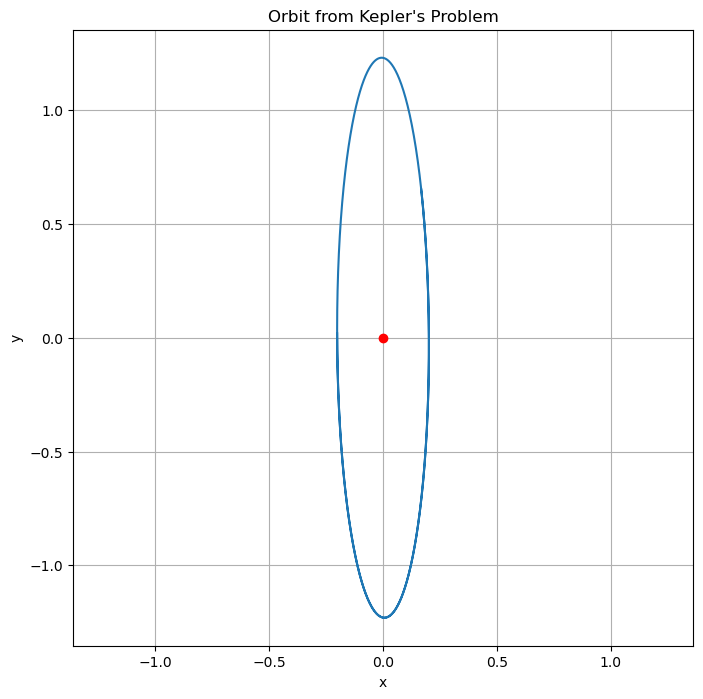

In [21]:
i = 2

E, V = torch.linalg.eigh(X[i][:,:3].T@X[i][:,:3])
xy0 = X[i][:,:3]@V
x0 = xy0[:,1]
y0 = xy0[:,2]

# Plot the orbit
plt.figure(figsize=(8, 8))
plt.plot(x0, y0)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Orbit from Kepler\'s Problem')
plt.grid(True)
plt.axis('equal')
plt.scatter(0, 0, color='red', zorder=5)
plt.show()